# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [29]:
!pip install datasets

Импорт необходимых библиотек

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [31]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [33]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [34]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [35]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [36]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [37]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [38]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

**Эксперимент 1 - БАЗОВАЯ МОДЕЛЬ**

In [39]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [40]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [41]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 90.50%
Лучшая accuracy для подхода mean: 91.18%


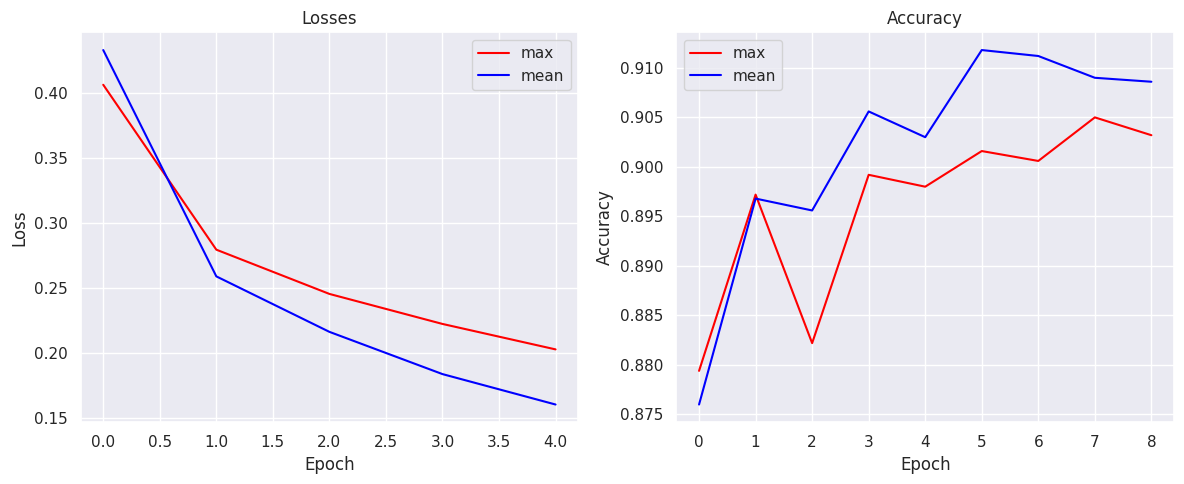

In [42]:
def plot_training_results(losses_type, acc_type):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Losses ---
    for (name, values), color in zip(losses_type.items(), ['red', 'blue', 'green', 'orange']):
        axes[0].plot(np.arange(len(values)), values, color=color, label=name)
    axes[0].set_title('Losses')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # --- Accuracy ---
    for (name, values), color in zip(acc_type.items(), ['red', 'blue', 'green', 'orange']):
        axes[1].plot(np.arange(len(values[1:])), values[1:], color=color, label=name)
        best = max(values)
        print(f"Лучшая accuracy для подхода {name}: {best*100:.2f}%")
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_results(losses_type, acc_type)

**Эксперимент 2 — GRU вместо RNN**

In [43]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', rnn_type: str = 'rnn', num_layers: int = 1
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        rnn_type = rnn_type.lower()
        if rnn_type == 'rnn':
            RNNLayer = nn.RNN
        elif rnn_type == 'gru':
            RNNLayer = nn.GRU
        elif rnn_type == 'lstm':
            RNNLayer = nn.LSTM
        else:
            raise ValueError(f"Unknown rnn_type: {rnn_type}")

        self.rnn = RNNLayer(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [B, T, H]
        output, _ = self.rnn(embeddings)          # [B, T, H]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [B, H]
        prediction = self.projection(self.non_lin(output))        # [B, num_classes]
        return prediction


In [44]:
losses_gru = []
acc_gru = []

model = CharLM(hidden_dim=256, vocab_size=len(vocab),
               aggregation_type='max', rnn_type='gru').to(device)
criterion = nn.CrossEntropyLoss()   # важно: без ignore_index
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'GRU epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'].to(device))
        loss = criterion(logits, batch['label'].to(device))
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

        if i % eval_steps == 0:
            model.eval()
            acc_gru.append(evaluate(model, eval_dataloader))
            model.train()

    losses_gru.append(sum(epoch_losses) / len(epoch_losses))

losses_type['gru'] = losses_gru
acc_type['gru'] = acc_gru


GRU epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

GRU epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

GRU epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

GRU epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

GRU epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для max: 90.50%
Лучшая accuracy для mean: 91.18%
Лучшая accuracy для gru: 91.26%


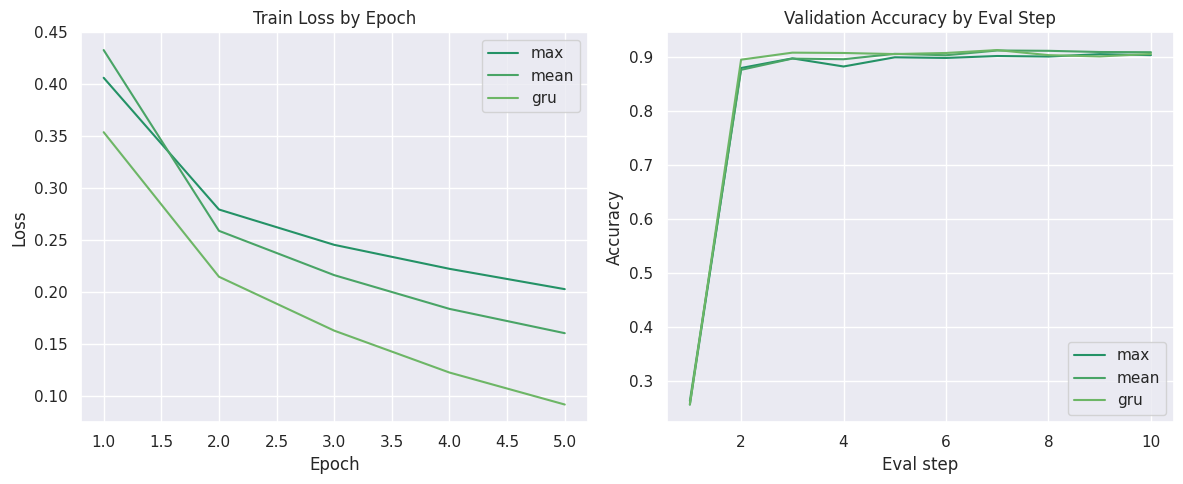

In [45]:
def plot_train_val(losses_type, acc_type):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Train Loss ---
    for name, losses in losses_type.items():
        axes[0].plot(np.arange(1, len(losses)+1), losses, label=name)
    axes[0].set_title("Train Loss by Epoch")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # --- Validation Accuracy ---
    for name, accs in acc_type.items():
        axes[1].plot(np.arange(1, len(accs)+1), accs, label=name)
        best = max(accs)
        print(f"Лучшая accuracy для {name}: {best*100:.2f}%")
    axes[1].set_title("Validation Accuracy by Eval Step")
    axes[1].set_xlabel("Eval step")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_train_val(losses_type, acc_type)

**Эксперимент 2 — двухслойный GRU (num_layers=2)**

GRU-2L epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

GRU-2L epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

GRU-2L epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

GRU-2L epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

GRU-2L epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для max: 90.50%
Лучшая accuracy для mean: 91.18%
Лучшая accuracy для gru: 91.26%
Лучшая accuracy для gru_2layers: 91.54%


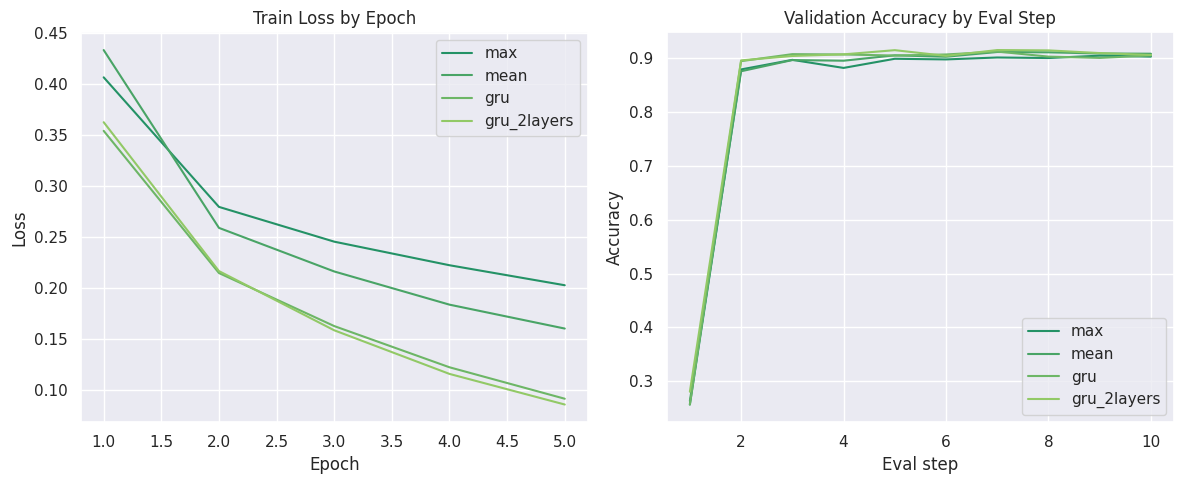

In [46]:
losses_gru2 = []
acc_gru2 = []

model = CharLM(hidden_dim=256, vocab_size=len(vocab),
               aggregation_type='max', rnn_type='gru', num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'GRU-2L epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'].to(device))
        loss = criterion(logits, batch['label'].to(device))
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

        if i % eval_steps == 0:
            model.eval()
            acc_gru2.append(evaluate(model, eval_dataloader))
            model.train()

    losses_gru2.append(sum(epoch_losses) / len(epoch_losses))

losses_type['gru_2layers'] = losses_gru2
acc_type['gru_2layers'] = acc_gru2

plot_train_val(losses_type, acc_type)


**Эксперимент 3 — обновим модель для эксперимента с ReLU**

In [47]:
class CharLMRelu(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', rnn_type: str = 'rnn', num_layers: int = 1
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        rnn_type = rnn_type.lower()
        if rnn_type == 'rnn':
            RNNLayer = nn.RNN
        elif rnn_type == 'gru':
            RNNLayer = nn.GRU
        elif rnn_type == 'lstm':
            RNNLayer = nn.LSTM
        else:
            raise ValueError(f"Unknown rnn_type: {rnn_type}")

        self.rnn = RNNLayer(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        # ⚡ меняем активацию на ReLU
        self.non_lin = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))
        return prediction


losses_relu = []
acc_relu = []

model = CharLMRelu(hidden_dim=256, vocab_size=len(vocab),
                   aggregation_type='max', rnn_type='gru', num_layers=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'ReLU-GRU epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'].to(device))
        loss = criterion(logits, batch['label'].to(device))
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

        if i % eval_steps == 0:
            model.eval()
            acc_relu.append(evaluate(model, eval_dataloader))
            model.train()

    losses_relu.append(sum(epoch_losses) / len(epoch_losses))

losses_type['gru_relu'] = losses_relu
acc_type['gru_relu'] = acc_relu


ReLU-GRU epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

ReLU-GRU epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

ReLU-GRU epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

ReLU-GRU epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

ReLU-GRU epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для gru: 91.26%
Лучшая accuracy для gru_relu: 91.58%


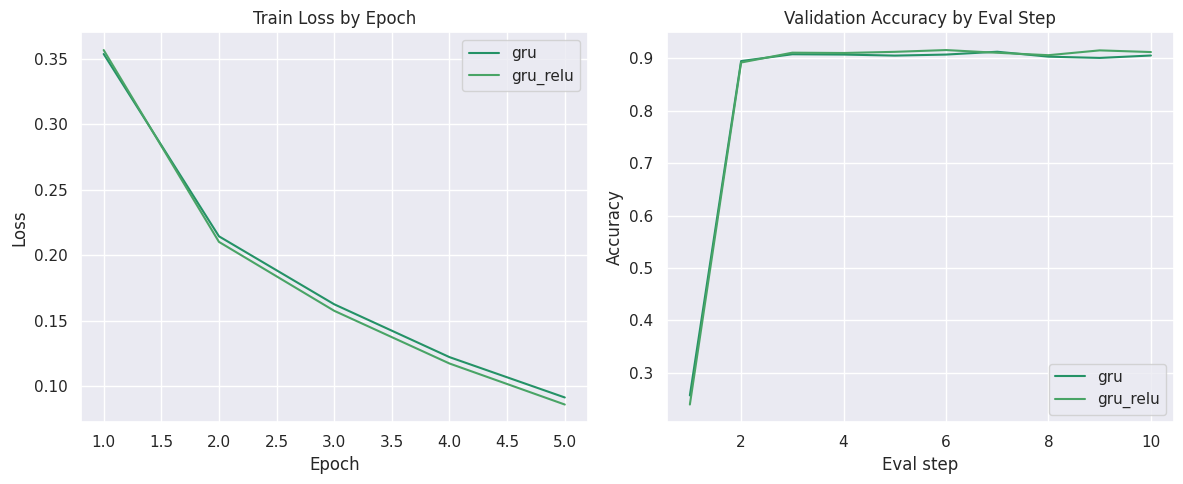

In [48]:
subset_losses = {k: v for k, v in losses_type.items() if k in ['gru', 'gru_relu']}
subset_acc    = {k: v for k, v in acc_type.items()    if k in ['gru', 'gru_relu']}

plot_train_val(subset_losses, subset_acc)

**Эксперимент 4 -  с Dropout**

In [49]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', rnn_type: str = 'rnn',
        num_layers: int = 1, dropout_p: float = 0.1
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        rnn_type = rnn_type.lower()
        if rnn_type == 'rnn':
            RNNLayer = nn.RNN
        elif rnn_type == 'gru':
            RNNLayer = nn.GRU
        elif rnn_type == 'lstm':
            RNNLayer = nn.LSTM
        else:
            raise ValueError(f"Unknown rnn_type: {rnn_type}")

        self.rnn = RNNLayer(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()          # оставим ту же активацию (чтобы не смешивать эксперименты)
        self.dropout = nn.Dropout(p=dropout_p)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [B, T, H]
        output, _ = self.rnn(embeddings)          # [B, T, H]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [B, H]
        prediction = self.projection(self.non_lin(output))        # [B, num_classes]
        return prediction


In [50]:
losses_gru_do03 = []
acc_gru_do03 = []

model = CharLM(
    hidden_dim=256, vocab_size=len(vocab),
    aggregation_type='max', rnn_type='gru', num_layers=1,
    dropout_p=0.3                                    # <<< изменение
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'GRU+Dropout(0.3) epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'].to(device))
        loss = criterion(logits, batch['label'].to(device))
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        if i % eval_steps == 0:
            model.eval()
            acc_gru_do03.append(evaluate(model, eval_dataloader))
            model.train()

    losses_gru_do03.append(sum(epoch_losses) / len(epoch_losses))

losses_type['gru_do03'] = losses_gru_do03
acc_type['gru_do03'] = acc_gru_do03


GRU+Dropout(0.3) epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

GRU+Dropout(0.3) epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

GRU+Dropout(0.3) epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

GRU+Dropout(0.3) epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

GRU+Dropout(0.3) epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для gru: 91.26%
Лучшая accuracy для gru_do03: 91.96%


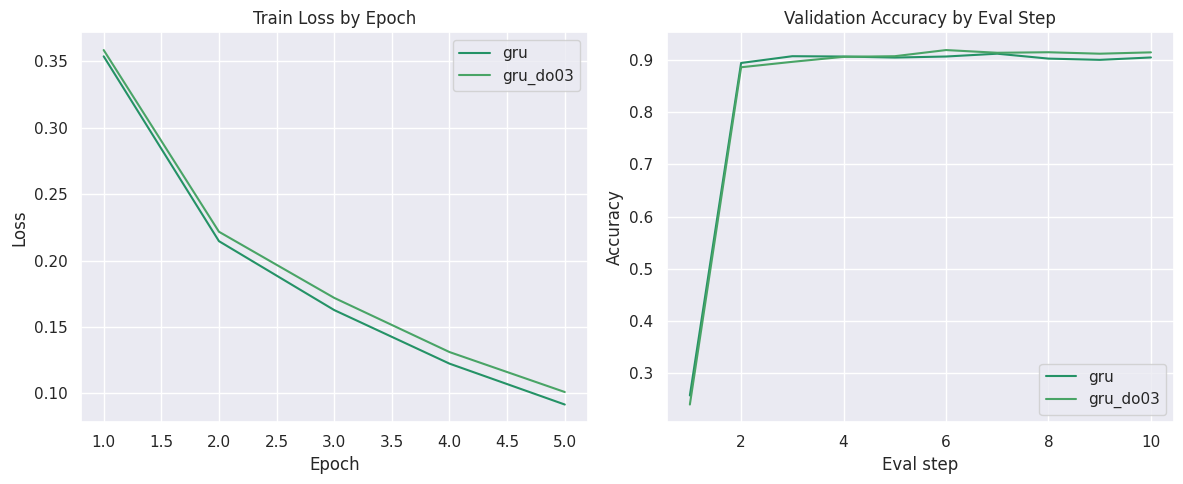

In [51]:
subset_losses = {k:v for k,v in losses_type.items() if k in ['gru','gru_do03']}
subset_acc    = {k:v for k,v in acc_type.items()    if k in ['gru','gru_do03']}
plot_train_val(subset_losses, subset_acc)

**Эксперимент 5 - Bidirectional GRU**

In [53]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', rnn_type: str = 'rnn',
        num_layers: int = 1, dropout_p: float = 0.1, bidirectional: bool = False
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        rnn_type = rnn_type.lower()
        if rnn_type == 'rnn':
            RNNLayer = nn.RNN
        elif rnn_type == 'gru':
            RNNLayer = nn.GRU
        elif rnn_type == 'lstm':
            RNNLayer = nn.LSTM
        else:
            raise ValueError(f"Unknown rnn_type: {rnn_type}")

        self.bidirectional = bidirectional
        self.rnn = RNNLayer(
            hidden_dim,
            hidden_dim,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=bidirectional
        )

        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.linear = nn.Linear(out_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_p)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)   # [B, T, H]
        output, _ = self.rnn(embeddings)           # [B, T, H] или [B, T, 2H]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]          # [B, H] или [B, 2H]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [B, H]
        prediction = self.projection(self.non_lin(output))        # [B, num_classes]
        return prediction


In [54]:
losses_bi_gru = []
acc_bi_gru = []

model = CharLM(
    hidden_dim=256, vocab_size=len(vocab),
    aggregation_type='max', rnn_type='gru',
    num_layers=1, bidirectional=True
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'BiGRU epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'].to(device))
        loss = criterion(logits, batch['label'].to(device))
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

        if i % eval_steps == 0:
            model.eval()
            acc_bi_gru.append(evaluate(model, eval_dataloader))
            model.train()

    losses_bi_gru.append(sum(epoch_losses) / len(epoch_losses))

losses_type['bi_gru'] = losses_bi_gru
acc_type['bi_gru'] = acc_bi_gru


BiGRU epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

BiGRU epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

BiGRU epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

BiGRU epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

BiGRU epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для gru: 91.26%
Лучшая accuracy для bi_gru: 91.14%


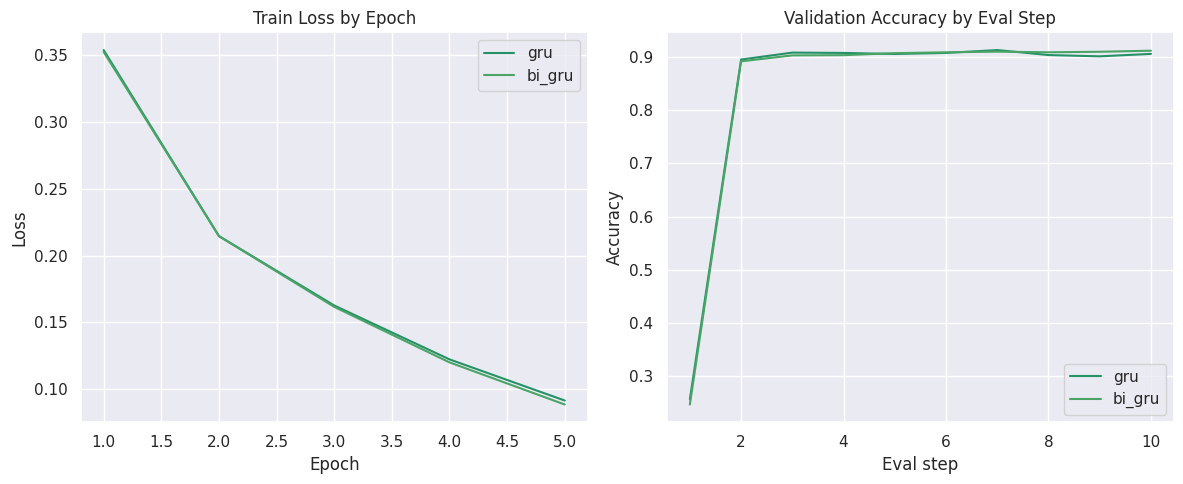

In [55]:
subset_losses = {k: v for k, v in losses_type.items() if k in ['gru', 'bi_gru']}
subset_acc    = {k: v for k, v in acc_type.items()    if k in ['gru', 'bi_gru']}
plot_train_val(subset_losses, subset_acc)


**ОТЧЕТ**

Результаты экспериментов
 - Baseline (RNN, max/mean pooling):
1. Max: 90.50%
2. Mean: 91.18%
 - GRU: 91.26%
 - GRU (2 слоя): 91.54%
 - GRU + ReLU активация: 91.58%
 - GRU + Dropout 0.3: 91.96% <----- лучший результат
 - Bi-GRU: 91.14%


Сходимость моделей выглядела достаточно стабильной:
- Baseline (RNN): графики loss и accuracy плавные, без резких скачков; качество улучшалось постепенно по эпохам.
- GRU и его модификации (2 слоя, ReLU, Bi-GRU): также демонстрируют стабильную сходимость. Иногда видны небольшие колебания на валидации, но они в пределах нормы (±0.2–0.3%), что связано с особенностями батчей.
- GRU + Dropout 0.3: сходимость самая «здоровая» — loss монотонно убывает, accuracy растёт и стабилизируется ближе к последним эпохам.


 Вывод:
- Почти все модификации GRU дали прирост по сравнению с бейзлайном.
- Лучшая модель — GRU с Dropout 0.3, accuracy 91.96%.
- Bi-GRU не дало улучшения (даже хуже, чем обычный GRU)